In [166]:
import gym
import random
import import_ipynb
import proj_env
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import json
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
random.seed(0)

the_n_env = proj_env.GridWorldEnv(render_mode='rgb_array')
the_n_env.reset(seed = 0)

down = np.array([1,0])
up = np.array([-1,0])
right = np.array([0,1])
left = np.array([0,-1])

action_to_direction = {1: right,2: left,3: down,4: up}


food_list = ["RedApple", "RedOnions", "YellowOnions", "Bread", "YellowCheese", "WhiteCheese",
         "RedBellPepper", "GreenBellPepper", "GreenApple", "YellowEgg", "WhiteEgg", "Butter",
         "Ham", "RedMeat", "WhiteMeat", "Salt", "Herbs"]

tools_list =[ "Pot", "Oven", "Knife", "MixingBowl"]

guest_list = ["Red","White","Green","Yellow"]

original_loc = the_n_env._Agent_location
plate_loc = the_n_env._Plate_location

size = the_n_env.size
print(size)



    

30


In [138]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/iy1616/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [125]:
def show_env(env):
    image_array = the_n_env._render_frame()

    plt.figure(figsize=(20, 20))
    # Display the image array
    plt.imshow(image_array)
    plt.axis('off')  # Hide the axis
    plt.show()


2000


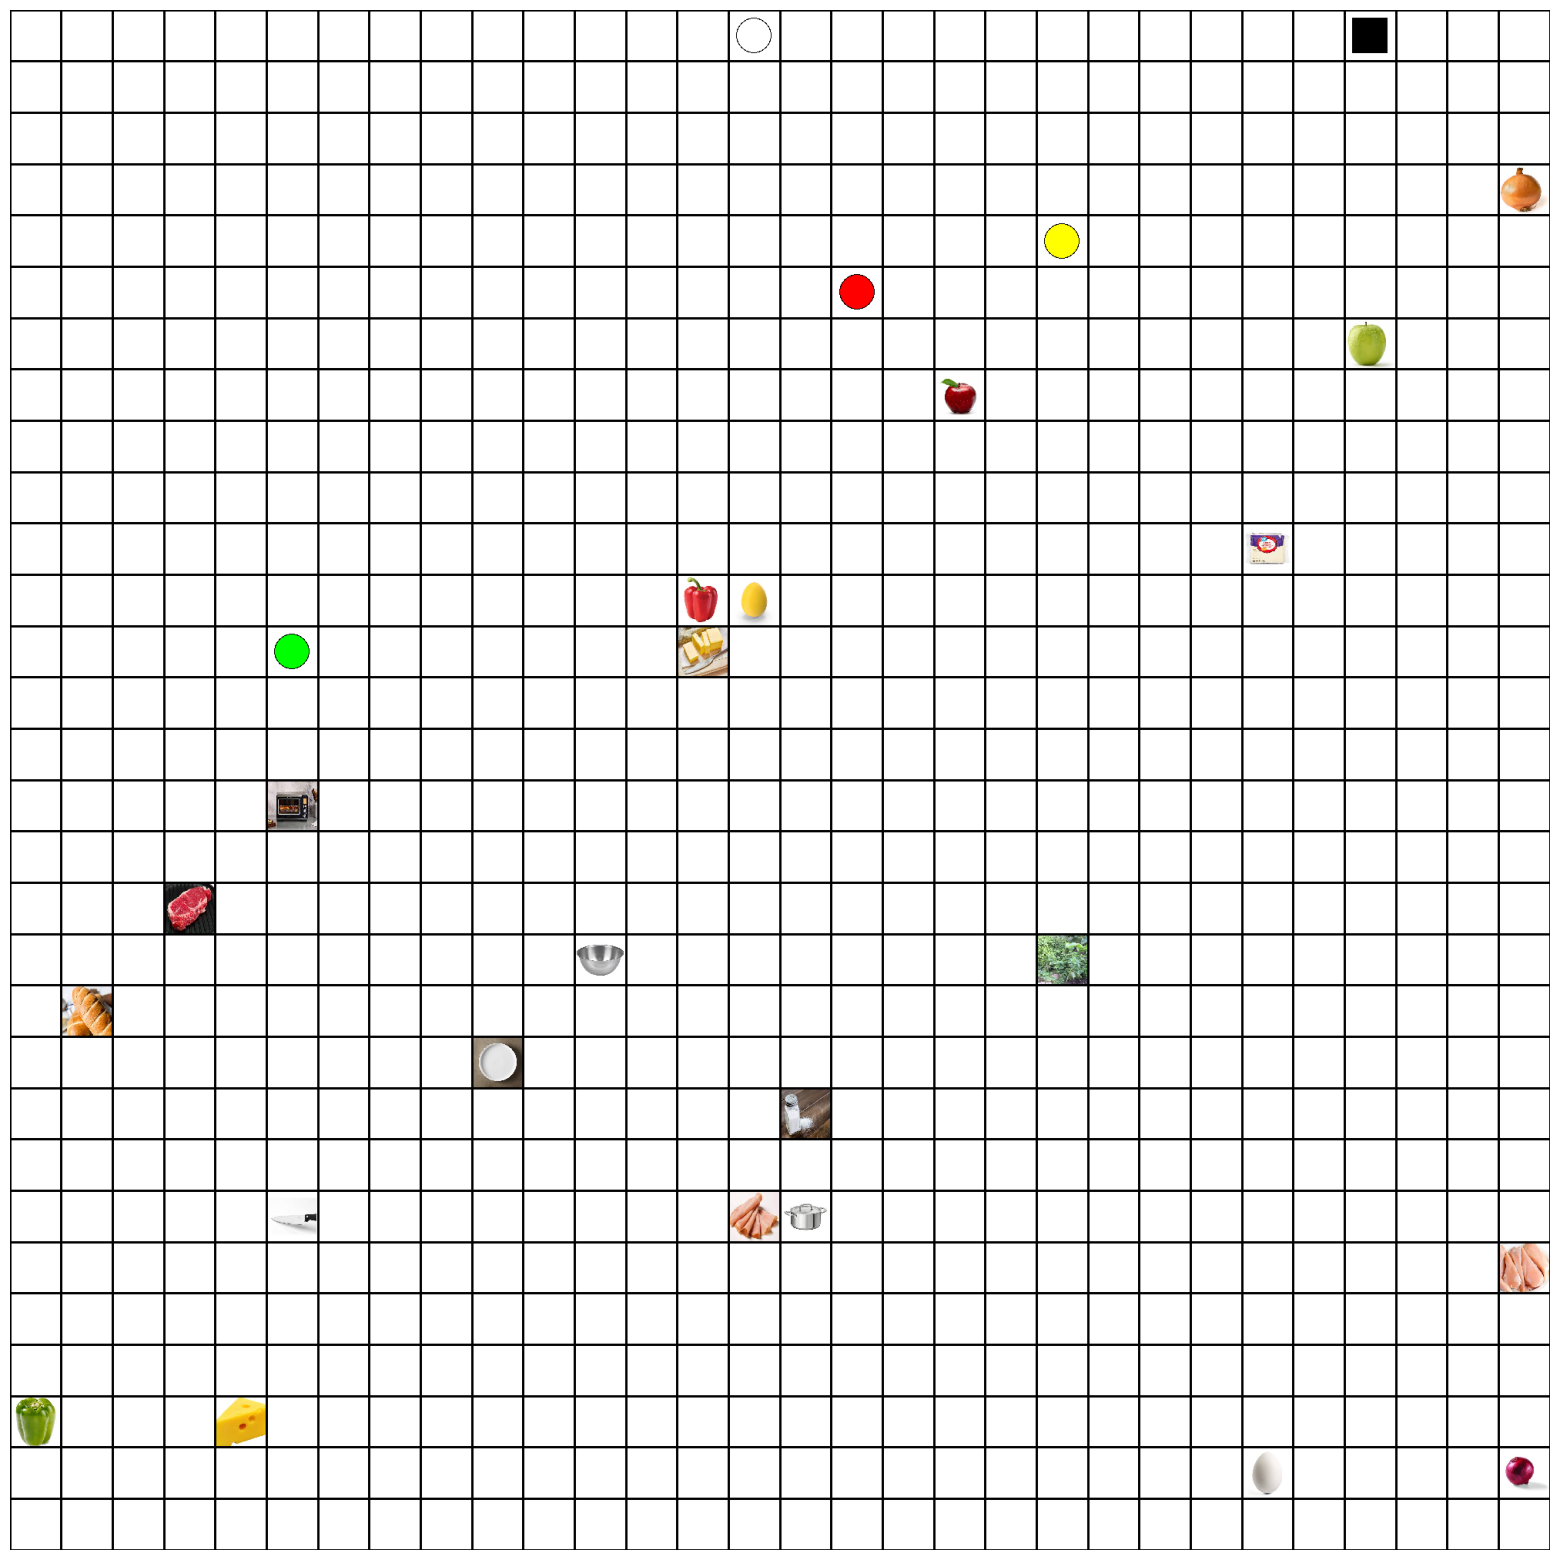

In [126]:
show_env(the_n_env)

In [127]:
def movingList(distance):
    
    x = distance[0]
    y = distance[1]
    lst = []
    a_lst = []
    if x < 0:
        for i in range(x,0):
            lst.append(1)
            a_lst.append("Right")
    elif x > 0:
        for i in range(x):
            lst.append(2)
            a_lst.append("Left")
    if y < 0:
        for i in range(y,0):
            lst.append(3)
            a_lst.append("Down")
    elif y > 0:
        for i in range(y):
            lst.append(4)
            a_lst.append("Up")

    return lst, a_lst

In [128]:
diff_loc = dict()
act_loc = dict()
for f in food_list:
    loc = getattr(the_n_env, "_"+f + "_location")
    distance = original_loc - loc
    x = distance[0]
    y = distance[1]
    lst,a_lst = movingList(distance)
    diff_loc[f] = lst
    act_loc[f] = a_lst

    distance_p = plate_loc - loc
    lst,a_lst = movingList(distance_p)
    o_lst , oa_lst = movingList(-distance_p)
    k = "Plate-"+f
    diff_loc[k] = lst
    act_loc[k] = a_lst

    k = f+"-Plate"
    diff_loc[k] = o_lst
    act_loc[k] = oa_lst

    for t in tools_list:
        t_loc = getattr(the_n_env, "_"+t + "_location")
        distance = original_loc - t_loc
        lst,a_lst = movingList(distance)
        diff_loc[t] = lst
        act_loc[t] = a_lst  
        
        distance = loc - t_loc
        lst,a_lst = movingList(distance)
        k = f+"-"+t
        diff_loc[k] = lst
        act_loc[k] = a_lst

        lst,a_lst = movingList(-distance)
        k = t+"-"+f
        diff_loc[k] = lst
        act_loc[k] = a_lst

        distance_p = t_loc - plate_loc
        lst,a_lst = movingList(distance_p)
        o_lst , oa_lst = movingList(-distance_p)
        k = t+"-Plate"
        diff_loc[k] = lst
        act_loc[k] = a_lst

        k = "Plate-"+t
        diff_loc[k] = o_lst
        act_loc[k] = oa_lst

        for g in guest_list:
            g_loc = getattr(the_n_env, "_"+g + "_location")
            distance = t_loc - g_loc
            lst,a_lst = movingList(distance)
            k = t+"-"+g
            diff_loc[k] = lst
            act_loc[k] = a_lst

            distance_p = plate_loc - g_loc
            lst,a_lst = movingList(distance_p)
            k = "Plate-"+g
            diff_loc[k] = lst
            act_loc[k] = a_lst

        for others_t in tools_list:
            if others_t!=t:
                other_loc = getattr(the_n_env, "_"+others_t + "_location")
                distance = t_loc - other_loc
                lst,a_lst = movingList(distance)
                k = t+"-"+others_t
                diff_loc[k] = lst
                act_loc[k] = a_lst

                lst,a_lst = movingList(-distance)
                k = others_t+"-"+t
                diff_loc[k] = lst
                act_loc[k] = a_lst
        
    for other in food_list:
        if other!=f:
            other_loc = getattr(the_n_env, "_"+other + "_location")
            distance = loc - other_loc
            lst,a_lst = movingList(distance)
            k = f+"-"+other
            diff_loc[k] = lst
            act_loc[k] = a_lst

            lst,a_lst = movingList(-distance)
            k = other+"-"+f
            diff_loc[k] = lst
            act_loc[k] = a_lst


diff_loc["Plate-Plate"] = []


In [129]:
def check_diff(diff_loc = diff_loc, k = None):
    for the_k in diff_loc.keys():
        if k in the_k:
            print(the_k)
            print(diff_loc[the_k])

In [162]:
check_diff(k = "Pan")

In [237]:
class BehaviorCloningModel(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_actions):
        super(BehaviorCloningModel, self).__init__()
        
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_actions)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [132]:
info = dict()
with open("699_recipe_data.json", "r") as f:
    d = json.load(f)
    for i in d["dataset"]:
      e = i["key"]
      if e not in info.keys():
          v = i["value"]
          n_v = set()
          for value in v:
              n_v.add(tuple(value))
          info[e] = n_v
      else:
          value = info[e]
          v = i["value"]
          n_v = set()
          for elements in v:
              n_v.add(tuple(elements))
          n_v = value.union(n_v)
          info[e] = n_v

#info key is command, value is set with multiple solutions and each solution type is tuple



In [133]:
def commandAnalysis(step):
    command = step.split(" ")[0]
    t = step.split(" ")[-1]
    target = ""
    target += t[0].upper()
    target += t[1:].lower()
    if target == "Onion":
        target = step.split(" ")[-2]+"Onions"
    elif target == "Apple" or target == "Egg" or target == "Meat" or target == "Cheese":
        target = step.split(" ")[-2]+target
    elif target == "Pepper":
        target = step.split(" ")[-3]+"Bell"+target
    elif target == "Bowl":
        target = "Mixing"+target
    elif target == "(turkey)":
        target = "WhiteMeat"
    elif target == "(beef)":
        target = "RedMeat"
    else:
        target = target
    
    return command, target



In [134]:
optimal_action = dict()
for key in info.keys():
    value = info[key]
    big_v = []
    for v in value:
        small_v = []
        last_pos = original_loc
        last_reach = None
        for step in v:
            command, target = commandAnalysis(step)
            if command == "Go":
                if last_reach == None:
                    small_v += diff_loc[target]
                    last_reach = target
                else:
                    small_v += diff_loc[last_reach+"-"+target]
                    last_reach = target
            elif command == "Take":
                small_v.append(5)
            
            elif command == "Prepare":
                small_v.append(6)

            elif command == "Place":
                k = last_reach+"-"+"Plate"
                small_v += diff_loc[k]
                small_v.append(6)
                last_reach = "Plate"

            elif command == "Serve":
                k = last_reach+"-"+target
                small_v += diff_loc[k]
                small_v.append(7)
                last_reach = None
        big_v.append(small_v)
    optimal_action[key] = big_v




In [152]:

tokenized = [word_tokenize(text) for text in optimal_action.keys()]

all_tokens = [token for text in tokenized  for token in text]
vocab = Counter(all_tokens)

word_to_index = {word: i + 1 for i, (word, _) in enumerate(vocab.items())}
print(word_to_index)

tokenized_texts_indices = [[word_to_index[token] for token in text] for text in tokenized]

# Define a maximum sequence length
max_length = max(len(text) for text in tokenized_texts_indices)

# Pad sequences with zeros
padded_sequences = [text + [0] * (max_length - len(text)) for text in tokenized_texts_indices]




{'Serve': 1, 'Apple': 2, 'Salad': 3, 'to': 4, 'Person': 5, 'in': 6, 'Red': 7, 'Cheese': 8, 'Platter': 9, 'for': 10, 'Customer': 11, 'White': 12, 'and': 13, 'Herb': 14, 'Spread': 15, 'Green': 16, 'Give': 17, 'the': 18, 'Yellow': 19, 'a': 20, 'Bell': 21, 'Pepper': 22, 'Grilled': 23, 'Sandwich': 24, 'Turkey': 25, 'Snack': 26, 'customer': 27, 'Butter': 28, 'Stuffed': 29, 'Peppers': 30, 'guest': 31, 'Beef': 32, 'Stir-Fry': 33, 'an': 34, 'A': 35, 'Wrap': 36, 'Steak': 37, 'Onion': 38, 'Tart': 39, 'Ham': 40, 'Omelette': 41}
[[1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0], [8, 9, 10, 11, 6, 12, 0, 0, 0, 0, 0, 0], [1, 8, 13, 14, 15, 4, 11, 6, 16, 0, 0, 0], [17, 18, 19, 11, 20, 21, 22, 3, 0, 0, 0, 0], [1, 23, 8, 24, 4, 5, 6, 7, 0, 0, 0, 0], [25, 24, 10, 5, 6, 12, 0, 0, 0, 0, 0, 0], [17, 2, 13, 8, 26, 4, 18, 27, 6, 16, 0, 0], [17, 14, 28, 4, 5, 6, 19, 0, 0, 0, 0, 0], [1, 29, 21, 30, 4, 18, 7, 31, 0, 0, 0, 0], [1, 32, 13, 21, 22, 33, 4, 11, 12, 0, 0, 0], [1, 20, 21, 22, 3, 4, 18, 5, 6, 7, 0, 0], [17, 20, 8, 

In [157]:
opt_short_action = []
for k in optimal_action.keys():
    v = optimal_action[k]

    if len(v) > 1:
        first = len(v[0])
        second = len(v[1])
        if first < second:
            opt_short_action.append(v[0])
        else:
            opt_short_action.append(v[1])
    else:
        opt_short_action.append(v[0])

print(opt_short_action)


max_l =  max(len(act) for act in opt_short_action)


padded_act = [act + [0] * (max_l - len(act)) for act in opt_short_action]


[[3, 3, 3, 3, 3, 3, 5, 2, 2, 2, 2, 2, 2, 2, 2, 3, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 6, 2, 2, 3, 3, 6, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7], [2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 1, 4, 4, 4, 4, 6, 1, 1, 1, 1, 4, 4, 4, 6, 6, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7], [2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 6, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 6, 2, 2, 3, 3, 6, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 7], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 1, 1, 1, 1, 1, 4, 4, 4, 4, 6, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4,

In [207]:
print(len(padded_act))
print(len(padded_sequences))

vocab_size = len(word_to_index) + 1  # Assuming word_to_index is your vocabulary index
embedding_dim = 128  # Example value
hidden_dim = 256  # Example value
num_actions = 8  # Assuming 7 different actions + 1 for padding



28
28


In [208]:
dataset = TensorDataset(torch.tensor(padded_sequences), torch.tensor(padded_act))

In [233]:
batch_size = 10  # You can adjust this according to your needs

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [242]:
model = BehaviorCloningModel(max_length, hidden_dim, max_l)

criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5000  # Example value

# model.train()
pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")
for epoch in pbar:
    for input_batch, target_batch in dataloader:  # Assuming dataloader is your data loader
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass

        outputs = model(input_batch.float())

        loss = criterion(outputs.float(), target_batch.float())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    pbar.set_postfix(Loss=loss,The_epoch=epoch+1)
   
    

Training: 100%|██████████| 5000/5000 [00:18<00:00, 263.41epoch/s, Loss=tensor(1.5294, grad_fn=<HuberLossBackward0>), The_epoch=5000]
